# Imports

In [66]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

# Image Display

Displaying some sample images from the data.

In [67]:
%matplotlib inline

def load_images_from_folder(folder='data', exts=('.jpg', '.jpeg', '.png', '.bmp')):
    files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.jpeg', '.png'))],
    key=lambda x: int(os.path.splitext(os.path.basename(x))[0])
)
    imgs = [cv2.imread(f) for f in files]
    names = files
    return imgs, names

def show_img(img, title=None, figsize=(10,6)):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    if title: plt.title(title)
    plt.axis('off')


In [68]:
def make_feature_detector(name='sift'):
    name = name.lower()
    if name == 'sift':
        try:
            return cv2.SIFT_create()
        except Exception:
            print("SIFT not available, falling back to ORB.")
            return cv2.ORB_create(5000)
    elif name == 'orb':
        return cv2.ORB_create(5000)
    else:
        raise ValueError("Unknown detector: " + name)

def detect_and_compute(img, detector):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = detector.detectAndCompute(gray, None)
    return kp, des


In [69]:
def make_matcher(descriptor_type='sift'):
    if descriptor_type == 'sift':
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        return cv2.FlannBasedMatcher(index_params, search_params)
    else:
        return cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

def match_descriptors(des1, des2, matcher, ratio=0.75):
    # knnMatch and Lowe's ratio test
    raw = matcher.knnMatch(des1, des2, k=2)
    good = []
    for m_n in raw:
        if len(m_n) < 2:
            continue
        m, n = m_n
        if m.distance < ratio * n.distance:
            good.append(m)
    return good


Found 85 images. Example: ['data\\1.jpeg', 'data\\2.jpeg', 'data\\3.jpeg']
Keypoints 101464 / 84123; good matches after ratio test: 18362
Keypoints 101464 / 84123; good matches after ratio test: 18362


(np.float64(-0.5), np.float64(8567.5), np.float64(5711.5), np.float64(-0.5))

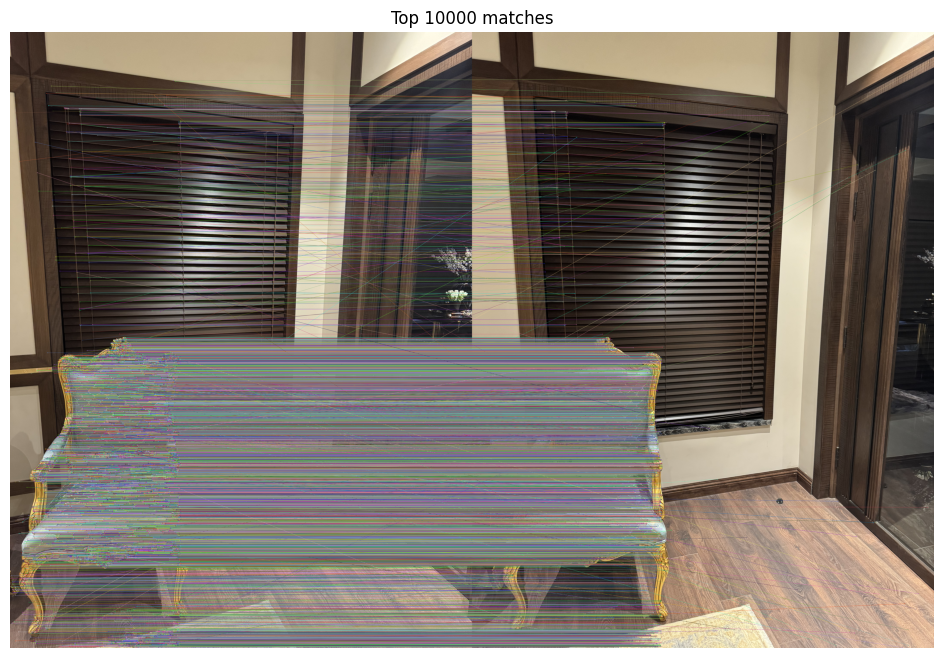

In [70]:
imgs, img_paths = load_images_from_folder('data')
print(f"Found {len(imgs)} images. Example: {img_paths[:3]}")

i1, i2 = 0, 1
img1, img2 = imgs[i1], imgs[i2]

detector = make_feature_detector('sift')
kp1, des1 = detect_and_compute(img1, detector)
kp2, des2 = detect_and_compute(img2, detector)

matcher = make_matcher('sift')
good = match_descriptors(des1, des2, matcher, ratio=0.75)

print(f"Keypoints {len(kp1)} / {len(kp2)}; good matches after ratio test: {len(good)}")

N = 10000
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good[:N], None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(16,8))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title(f"Top {min(N,len(good))} matches")
plt.axis('off')


In [71]:
def build_intrinsics_from_image(img):
    h, w = img.shape[:2]
    fx = max(h, w)
    fy = fx
    cx = w / 2.0
    cy = h / 2.0
    K = np.array([[fx, 0, cx],
                  [0, fy, cy],
                  [0,  0,  1]], dtype=np.float64)
    return K

def matched_keypoints(kp1, kp2, matches):
    pts1 = np.array([kp1[m.queryIdx].pt for m in matches], dtype=np.float64)
    pts2 = np.array([kp2[m.trainIdx].pt for m in matches], dtype=np.float64)
    return pts1, pts2


In [72]:
def two_view_reconstruct(img1, img2, kp1, kp2, des1, des2, matches, K):
    pts1, pts2 = matched_keypoints(kp1, kp2, matches)
    E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    mask = mask.ravel().astype(bool)
    pts1_in = pts1[mask]
    pts2_in = pts2[mask]
    print(f"Essential estimated. Inliers: {len(pts1_in)}")

    _, R, t, mask_pose = cv2.recoverPose(E, pts1_in, pts2_in, K)
    
    mask_pose_bool = mask_pose.ravel().astype(bool)
    used1 = pts1_in[mask_pose_bool]
    used2 = pts2_in[mask_pose_bool]
    print(f"recoverPose used {len(used1)} points")
    
    if len(used1) < 4:
        print("Very few points after pose recovery. Check your input images.")
        return None, None, None, used1, used2

    M1 = (K @ np.hstack((np.eye(3), np.zeros((3,1))))).astype(np.float64)
    M2 = (K @ np.hstack((R, t))).astype(np.float64)
    
    p1 = used1.T.astype(np.float64)
    p2 = used2.T.astype(np.float64)
    
    print(f"M1 shape: {M1.shape}, M2 shape: {M2.shape}, p1 shape: {p1.shape}, p2 shape: {p2.shape}")
    
    pts4d_h = cv2.triangulatePoints(M1, M2, p1, p2)
    pts3d = (pts4d_h[:3] / pts4d_h[3]).T

    def count_in_front(R, t, pts3d):
        z1 = pts3d[:,2]
        pts_cam2 = (R @ pts3d.T) + t
        z2 = pts_cam2[2,:]
        return np.sum((z1 > 0) & (z2 > 0))
    in_front = count_in_front(R, t, pts3d)
    print(f"Points in front of both cameras: {in_front} / {pts3d.shape[0]}")
    print(f"3D points range - X: [{pts3d[:,0].min():.2f}, {pts3d[:,0].max():.2f}], Y: [{pts3d[:,1].min():.2f}, {pts3d[:,1].max():.2f}], Z: [{pts3d[:,2].min():.2f}, {pts3d[:,2].max():.2f}]")

    return R, t, pts3d, used1, used2


In [73]:
K = build_intrinsics_from_image(img1)
R, t, pts3d, used1, used2 = two_view_reconstruct(img1, img2, kp1, kp2, des1, des2, good, K)
print("Triangulated points:", pts3d.shape if pts3d is not None else "None")


Essential estimated. Inliers: 13464
recoverPose used 13463 points
M1 shape: (3, 4), M2 shape: (3, 4), p1 shape: (2, 13463), p2 shape: (2, 13463)
Points in front of both cameras: 13463 / 13463
3D points range - X: [-10.64, 9.68], Y: [-11.52, 14.60], Z: [5.97, 29.86]
Triangulated points: (13463, 3)


In [74]:
def save_point_cloud_ply(points3d, colors=None, filename='two_view_cloud.ply'):
    if colors is None:
        colors = np.tile(np.array([200,200,200], dtype=np.uint8), (len(points3d),1))
    pts = o3d.geometry.PointCloud()
    pts.points = o3d.utility.Vector3dVector(points3d)
    pts.colors = o3d.utility.Vector3dVector(colors.astype(float)/255.0)
    o3d.io.write_point_cloud(filename, pts)
    print(f"Wrote {filename}")

def visualize_point_cloud(points3d, camera_poses=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points3d)
    if points3d.shape[0] > 0:
        pcd.paint_uniform_color([0.7,0.7,0.7])
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)
    if camera_poses:
        for (R,t) in camera_poses:
            mesh = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2)
            T = np.eye(4)
            T[:3,:3] = R
            T[:3,3] = t.ravel()
            mesh.transform(T)
            vis.add_geometry(mesh)
    vis.run()
    vis.destroy_window()

save_point_cloud_ply(pts3d, filename='two_view_cloud.ply')
# visualize_point_cloud(pts3d, camera_poses=[(np.eye(3), np.zeros((3,1))), (R, t)])  # uncomment to open a window


Wrote two_view_cloud.ply


In [75]:
def plot_point_cloud_matplotlib(points3d, colors=None):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    x, y, z = points3d[:,0], points3d[:,1], points3d[:,2]

    if colors is None:
        ax.scatter(x, y, z, s=2)
    else:
        ax.scatter(x, y, z, c=colors/255.0, s=2)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()


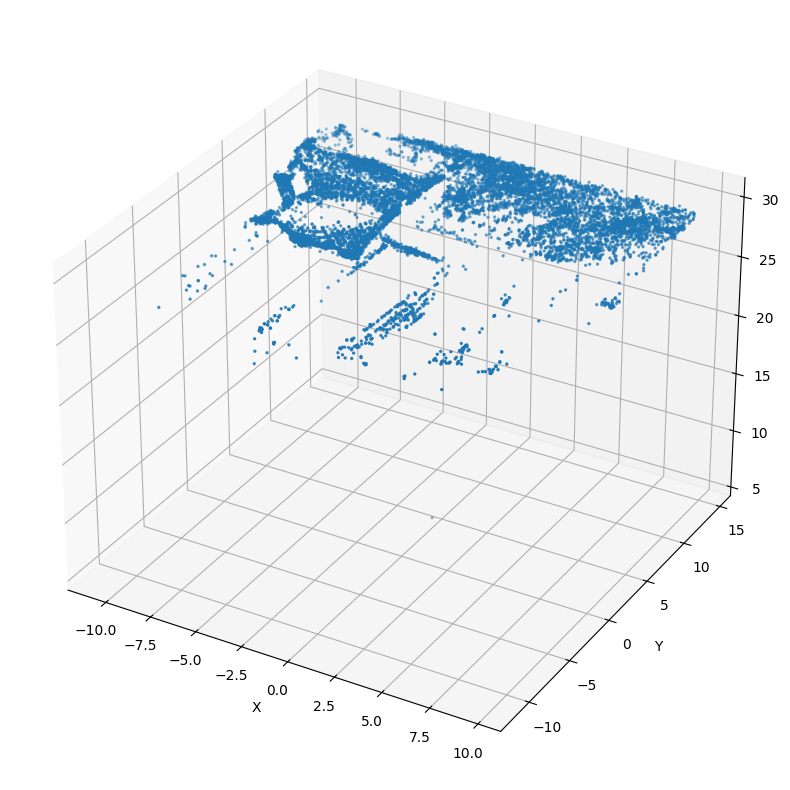

In [76]:
plot_point_cloud_matplotlib(pts3d) 

# Week 3

- Made point cloud using MetaShape

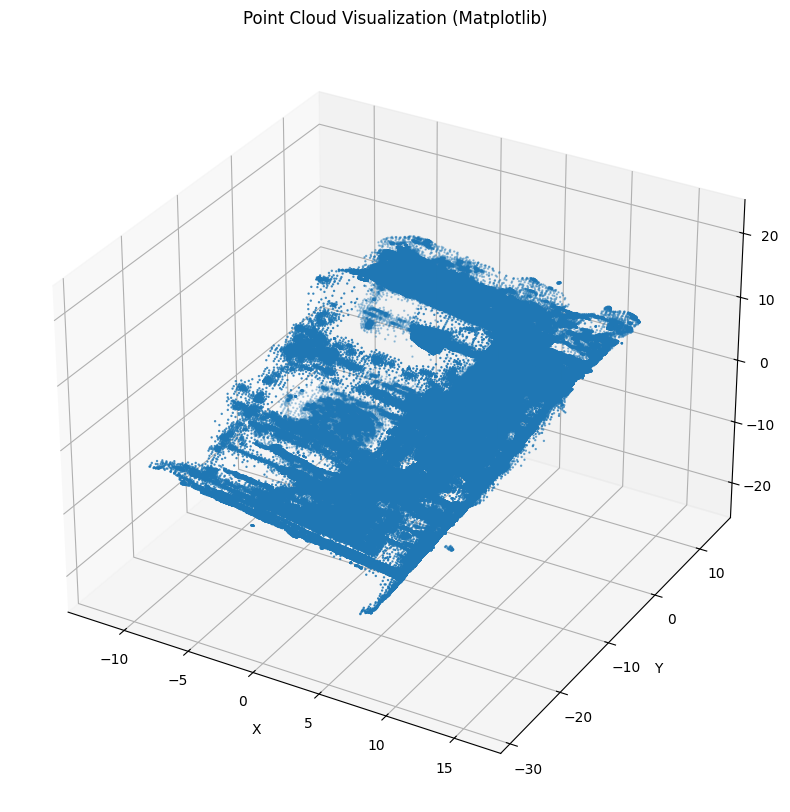

In [ ]:
pcd = o3d.io.read_point_cloud("sfm_final.ply")
pts = np.asarray(pcd.points)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=0.5)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("Point Cloud Visualization (Matplotlib)")
plt.show()


In [ ]:
pcd = o3d.io.read_point_cloud("sfm_final.ply")

print(pcd)
print("Number of points:", len(pcd.points))

o3d.visualization.draw_geometries([pcd])


PointCloud with 1673257 points.
Number of points: 1673257
